![alt text](https://www.auth.gr/sites/default/files/banner-horizontal-282x100.png)
# Advanced Topics in Machine Learning - Assignment 2 - Part C


## Active Learning - Uncertainty Sampling method for Instance Evaluation

#### Useful library documentation, references, and resources used on Assignment:

* DeliciousMIL Dataset: <https://github.com/hsoleimani/MLTM/tree/master/Data/Delicious>
* scikit-learn ML library (aka *sklearn*): <http://scikit-learn.org/stable/documentation.html>
* Logistic Regression Classifier: <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html>
* Classifier Accuracy score: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html>
* Model evaluation: quantifying the quality of predictions: <https://scikit-learn.org/stable/modules/model_evaluation.html>


# 0. __Install packages - Import necessary libraries__

In [4]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


# 1. __Download Required Dataset__
#### Use DeliciousMIL dataset from its GitHub repository. Dataset consist of 4 separate data files

In [5]:
# Download Data from Internet
# https://github.com/hsoleimani/MLTM/tree/master/Data/Delicious

# I prefer to use locally stored dataset files, located in directory 'raw_data'.
# Paths to required data files:
train_data = 'raw_data/train-data.dat'
train_labels = 'raw_data/train-label.dat'
test_data = 'raw_data/test-data.dat'
test_labels = 'raw_data/test-label.dat'

# 2. __Data Preprocessing__

## 2.0 Definitions of fuctions used in this part

In [10]:
def process_raw_data(data_fnames, labels_fnames):
    '''
    Method to read and process data needed for this part of Assignment.
    
    Imports:
        Relative paths to local files containing independent and
        dependent variables
    
    Returns:
        Lists on preprocessed train and test dependent and independent variables
    
    Basic procedure:
        1. Data is read from appropriate files on disc. Text is already
           stemmed and stop-word are removed
        2. Independent variables (text) are preprocessed and cleaned:
            - Remove <##> patterns indicating number of sentences per doc
              and number of words per sentence
            - remove multiple spaces
        3. Dependent variables (labels) are removed except of the most frequent one
    '''
    # Process Data files
    clean_files = []
    for datafile in data_fnames:
        # Read file from disc
        file = open(datafile).readlines()
        # Each file is a list of docs
        # Structure to hold cleaned docs
        clean_doc = []
        # Basic preprocessing procedure
        for doc in file:
            # Clean each doc
            # Remove <##> patterns
            doc = re.sub('<[0-9]+>','',doc).strip()
            # Remove multiple spaces
            doc = re.sub('\s+',' ',doc).strip()
            clean_doc.append(doc)
        clean_files.append(clean_doc)
    del file, clean_doc, 
    
    # Process Labels files
    print('Finding the most frequent label among 20 labels:')
    data = pd.read_csv(labels_fnames[0], delimiter = ' ', header = None)
    for i in range(20):
        print('\tTrain samples assigned to label %d: %d' %(i, data.iloc[:][i][data.iloc[:][i] == 1].count()))
    print('Most frequent label is label: %d' %data.sum(axis=0).idxmax())
    
    clean_labels = []
    for labels in labels_fnames:
        # Read file as csv
        data = pd.read_csv(labels, delimiter = ' ', header = None)
        # There are in total 20 columns, one for each class. I only need to keep
        # the labels correspond to the most frequent class.
        # Find index of column with max sum() and keep just this column
        clean_labels.append(data.iloc[:][data.sum(axis=0).idxmax()])        
    del data
    
    # Data sets to return (as lists)
    train_data = clean_files[0]
    train_labels = list(clean_labels[0])
    test_data_total = clean_files[1]
    test_labels_total = list(clean_labels[1])
    
    return(train_data,train_labels,test_data_total,test_labels_total)


def divide_data_labels(data, labels, split_factor):
    '''
    Function to split data and corresponding labels sets into two parts.
    First part takes as many elements as specified by split_factor.
    
    Imports:
        1. Lists containing the sets of data and labels to split
        2. A float number in range (0,1) indicating the split point
        
    Returns:
        Lists with resulting splitted data and labels
    '''
    # Total indices
    idx = np.arange(len(data))
    # Randomly (select wo replacement) select the indices of elements to participate
    # in first part
    ps_idx = sorted(np.random.choice(len(data), size=int(len(data)*split_factor), replace=False))
    # Find (using set subtraction) the indices of elements to participate in second part
    ts_idx = np.setdiff1d(idx, ps_idx)
    # Same functionality using list comprehension
#    ts_idx = [x for x in range(len(data)) if x not in ps_idx]
    
    # Split data and labels to corresponding parts
    fp_data = [data[x] for x in ps_idx]
    fp_labels = [labels[x] for x in ps_idx]
    sp_data = [data[x] for x in ts_idx]
    sp_labels = [labels[x] for x in ts_idx]

    return(fp_data,fp_labels,sp_data,sp_labels)

## 2.1 Process data from disc

In [11]:
# Paths of files holding the data
data_filenames = [
        'raw_data/train-data.dat',
        'raw_data/test-data.dat'
        ]

# Paths of files holding the labels
labels_filenames = [
            'raw_data/train-label.dat',
            'raw_data/test-label.dat'
            ]

# Process raw data to create necessary train and test data sets
X_train, y_train, X_test_total, y_test_total = process_raw_data(data_filenames, labels_filenames)

Finding the most frequent label among 20 labels:
	Train samples assigned to label 0: 2050
	Train samples assigned to label 1: 479
	Train samples assigned to label 2: 3181
	Train samples assigned to label 3: 799
	Train samples assigned to label 4: 2203
	Train samples assigned to label 5: 1211
	Train samples assigned to label 6: 1471
	Train samples assigned to label 7: 2221
	Train samples assigned to label 8: 1559
	Train samples assigned to label 9: 1004
	Train samples assigned to label 10: 1034
	Train samples assigned to label 11: 939
	Train samples assigned to label 12: 1049
	Train samples assigned to label 13: 725
	Train samples assigned to label 14: 830
	Train samples assigned to label 15: 898
	Train samples assigned to label 16: 598
	Train samples assigned to label 17: 1001
	Train samples assigned to label 18: 411
	Train samples assigned to label 19: 224
Most frequent label is label: 2


In [ ]:
# In case I want to use just a small random part of initial train data to avoid overfitting
if(0):
    # How many samples to keep
    keep = 1500
    # Randomly select (wo replacement) the indices of samples to keep
    keep_idx = sorted(np.random.choice(len(X_train), size=keep, replace=False))
    # Train data to keep
    X_train = [X_train[x] for x in keep_idx]
    # Corresponding labels
    y_train = [y_train[x] for x in keep_idx]

## 2.2 Basic Uncertainty Sampling procedure

In [589]:
# How many times to repeat Uncertainty Sampling experiment
repeats = 10

In [590]:
# Structures to hold results from all experiments
# Total results for uncertainty_sampling
total_us_results = []
# Total results for random_sampling
total_rnd_results = []


for i in range(repeats):
    print('Round %d' %i)
    
    # In each experiment I use different split of test set, otherwise the
    # uncertainty sampling results should be the same among all experiments
    X_pool_set, y_pool_set, X_test, y_test = divide_data_labels(X_test_total, y_test_total, 0.5)

    # Vectorize independent variables to use them in sklearn algorithms
    # Vectorizer is trained on train set independent variables and then transforms
    # all independent variables
    vectorizer = CountVectorizer()
    X_train_v = vectorizer.fit_transform(X_train)
    X_pool_set_v = vectorizer.transform(X_pool_set)
    X_test_v = vectorizer.transform(X_test)

    # Calculate classification probabilities for all samples in current pool_set
    # using standrad classifier trained on initial train set
    clf = LogisticRegression()
    clf.fit(X_train_v, y_train)
    # Calculate classification probabilities for all samples in pool_set
    probabilities = clf.predict_proba(X_pool_set_v)
    
    # predict_proba() returns for each sample a tuple of probabilities for the
    # sample to belong to class 0 or class 1
    # I subtract the two probabilities values for each sample. The closer is the
    # result to 0, the more uncertain is the sample
    scores = np.abs(probabilities[:,0] - probabilities[:, 1])

    # Structures to hold results from current experiment
    num_samples = []
    us_results = []
    rnd_results = []
    
    # Use various queries
    for num_queries in (0, 150, 250, 350, 400, 450, 500, 750, 1000, 1500):
#     for num_queries in (0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000):
        # Add current number of queries
        num_samples.append(num_queries)

        # First will be executed the random_sampling procedure
        # Using random selection wo replacement select num_queries examples from pool_set.
        # For convenience I will work with the corresponding indices
        idx_rnd = np.random.choice(len(X_pool_set), num_queries, replace=False)
        # Add randomly selected samples to existed train ones
        X_rnd = [X_pool_set[x] for x in idx_rnd]
        X_plus = np.concatenate((X_train, X_rnd))
        # Vectorize resulting total independent variable
        X_plus_v = vectorizer.transform(X_plus)
        # Add randomly selected samples labels to existed train set labels y_pool_set
        y_rnd = [y_pool_set[x] for x in idx_rnd]
        y_plus = np.concatenate((y_train, y_rnd))
        # Train classifier on augmented data sets
        clf.fit(X_plus_v, y_plus)
        # Calculate and save trained classifier accuracy achieved on test set
        rnd_results.append(accuracy_score(y_test, clf.predict(X_test_v)))

        
        # Repeat the same procedure using uncertainty_sampling this time
        
        # Indices of ranked most uncertain classified samples on pool_set
        idx_rankings = np.argsort(scores)[:num_queries]
        # Add selected samples to existed train ones
        X_us = [X_pool_set[x] for x in idx_rankings]
        X_plus = np.concatenate((X_train, X_us))
        # Vectorize resulting total independent variable
        X_plus_v = vectorizer.transform(X_plus)
        # Add randomly selected samples labels to existed train set labels y_pool_set
        y_us = [y_pool_set[x] for x in idx_rankings]
        y_plus = np.concatenate((y_train, y_us))
        # Train classifier on augmented data sets
        clf.fit(X_plus_v, y_plus)
        # Calculate and save trained classifier accuracy achieved on test set
        us_results.append(accuracy_score(y_test, clf.predict(X_test_v)))

    # Store results from current experiment
    total_rnd_results.append(rnd_results)
    total_us_results.append(us_results)


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


## 2.3 Manipulate results

In [591]:
# Calculate mean values of all experiments
# Results must be np.arrays to use them with matplotlib
if(repeats > 1):
    # Random Sampling results
    total_rnd_results.append(np.mean(total_rnd_results, axis=0))
    # Uncertainty Sampling results
    total_us_results.append(np.mean(total_us_results, axis=0))

## 2.4 Plot results

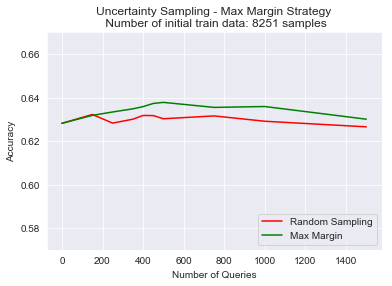

In [599]:
def plot_results(samples, rnd_results, us_results, train_len):
    sns.set_style("darkgrid")
    plt.plot(samples, rnd_results[-1:][0], 'red', 
             samples, us_results[-1:][0], 'green',)
    plt.legend(['Random Sampling', 'Max Margin'], loc=4)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Queries')
    plt.title('Uncertainty Sampling - Max Margin Strategy\n Number of initial train data: %d samples' %train_len)
    plt.ylim([0.57,0.67])
    
plot_results(num_samples,total_rnd_results,total_us_results,len(X_train))

# Save total results and graph
if(0):
    plt.savefig('results/Uncertainty Sampling - Max Margin Strategy_' + str(len(X_train))+ ' train samples.jpg')
    results = (total_us_results,total_rnd_results)
    pickle.dump(results, open('results/Total results_' + str(len(X_train))+ ' train samples.pkl', "wb"))

# 3. __Discussion__

#### It's obvious that Uncertainty Sampling method constantly delivers better results (concerning accuracy of the trained model) compared to Random Sampling method. 
#### Looking closer to Random Sampling curve one can say that our model is already overfitted since adding new samples to train set actually reduces accuracy.
#### Maybe this is due to using the whole train set consisting of over 8.200 samples.
#### In next steps I try to reproduce the above results (of ~63-64% accuracy) by using just a portion of train set. Results of representative trials are shown below. 

### Using 8251 samples as train set

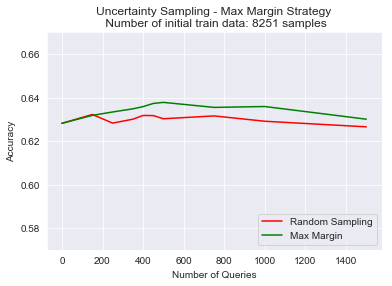

In [600]:
# Load stored results
total_us_results_8251,total_rnd_results_8251 = pickle.load(open('results/Total results_8251 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_8251,total_us_results_8251,8251)

### Using 1500 samples as train set

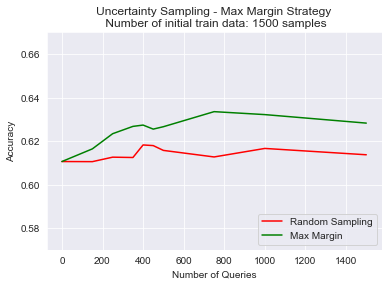

In [594]:
# Load stored results
total_us_results_1500,total_rnd_results_1500 = pickle.load(open('results/Total results_1500 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_1500,total_us_results_1500,1500)

### Using 1000 samples as train set

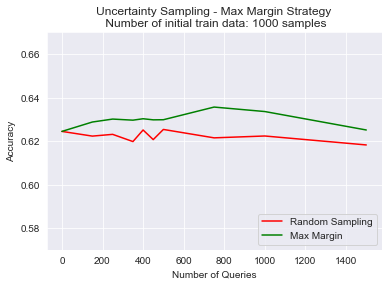

In [595]:
# Load stored results
total_us_results_1000,total_rnd_results_1000 = pickle.load(open('results/Total results_1000 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_1000,total_us_results_1000,1000)

### Using 850 samples as train set

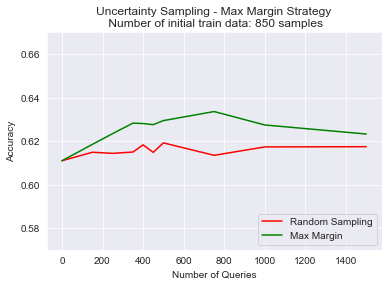

In [596]:
# Load stored results
total_us_results_850,total_rnd_results_850 = pickle.load(open('results/Total results_850 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_850,total_us_results_850,850)

### Using 650 samples as train set

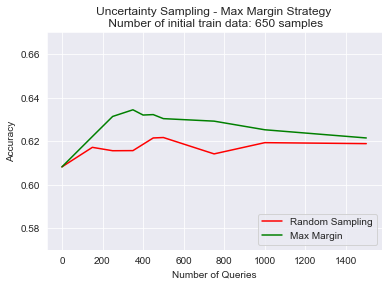

In [597]:
# Load stored results
total_us_results_650,total_rnd_results_650 = pickle.load(open('results/Total results_650 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_650,total_us_results_650,650)

### Using 500 samples as train set

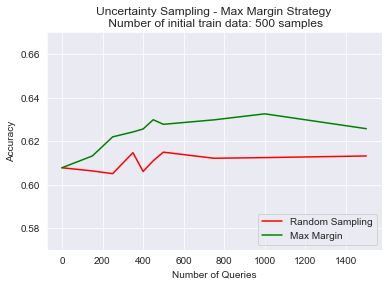

In [598]:
# Load stored results
total_us_results_500,total_rnd_results_500 = pickle.load(open('results/Total results_500 train samples.pkl', "rb"))
plot_results(num_samples,total_rnd_results_500,total_us_results_500,500)

#### The above results show clearly that, by taking advantage of Active Learning/Uncertainty Sampling technique, one could approach to a great extent the total performance, achieved by model trained to full train set, by using only a small portion of it.